In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import scipy as sp
import IPython
import sys
import sklearn
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = (15,13)

In [2]:
#loading the datasets
train = pd.read_csv("train_HPB.csv")
test = pd.read_csv("test_HPB.csv")

In [3]:
#view on train dataset
train.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
#shape of trainset
train.shape

(13320, 9)

In [5]:
#view on test dataset
test.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,Ready To Move,Brookefield,2 BHK,Roeekbl,1225,2.0,2.0,NaN
1,Plot Area,Ready To Move,Akshaya Nagar,9 Bedroom,NaN,2400,9.0,2.0,NaN
2,Plot Area,18-Apr,Hennur Road,4 Bedroom,Saandtt,1650,5.0,2.0,NaN
3,Super built-up Area,Ready To Move,Kodichikkanahalli,3 BHK,Winerri,1322,3.0,1.0,NaN
4,Super built-up Area,Ready To Move,Konanakunte,2 BHK,AmageSa,1161,2.0,1.0,NaN


In [6]:
#shape of testset
test.shape

(1480, 9)

In [7]:
#information about the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [8]:
#creating a source feature to combine the train and test datasets for preprocessing
train["source"]="train"
test["source"]="test"

In [9]:
#combining the train and test datasets in a dataframe
df = pd.concat([train,test], ignore_index = True)
df.reset_index(drop=True)
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,source
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,train
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,train
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,train
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,train
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,train


In [10]:
del df['society']

In [11]:
#getting features with non numerical  or catagorical values
df_catagory = df.select_dtypes(exclude=np.number).drop(columns=["source"])
df_catagory.head()

,area_type,availability,location,size,total_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200


In [12]:
df_catagory_corr = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
df_catagory_corr

,area_type,availability,location,size,total_sqft,bath,balcony,price,source
area_type,1.000000,-0.094818,0.127354,0.221231,-0.076890,0.150269,0.042073,-0.113867,0.008205
availability,-0.094818,1.000000,-0.085423,-0.054076,0.080674,-0.013574,-0.059772,0.148832,0.009430
location,0.127354,-0.085423,1.000000,0.157029,-0.041377,0.096707,0.034403,-0.068879,0.035024
size,0.221231,-0.054076,0.157029,1.000000,-0.016423,0.543023,0.016346,-0.051686,0.024354
total_sqft,-0.076890,0.080674,-0.041377,-0.016423,1.000000,0.107017,-0.004782,0.149441,0.060627
bath,0.150269,-0.013574,0.096707,0.543023,0.107017,1.000000,0.016967,-0.019290,0.008749
balcony,0.042073,-0.059772,0.034403,0.016346,-0.004782,0.016967,1.000000,-0.043658,0.000485
price,-0.113867,0.148832,-0.068879,-0.051686,0.149441,-0.019290,-0.043658,1.000000,-0.213660
source,0.008205,0.009430,0.035024,0.024354,0.060627,0.008749,0.000485,-0.213660,1.000000


In [13]:
#check for null values in the df_catagory
df_catagory.isna().sum()

area_type        0
availability     0
location         1
size            18
total_sqft       0
dtype: int64

In [14]:
df_catagory['area_type'].value_counts()

Super built-up  Area    9736
Built-up  Area          2688
Plot  Area              2279
Carpet  Area              97
Name: area_type, dtype: int64

In [15]:
df_catagory['area_type'] = df_catagory['area_type'].replace({'Super built-up  Area':'cat1','Built-up  Area':'cat2', 'Plot  Area':'cat3', 'Carpet  Area':'cat4'})
df_catagory['area_type'].head(20)

0     cat1
1     cat3
2     cat2
3     cat1
4     cat1
5     cat1
6     cat1
7     cat1
8     cat1
9     cat3
10    cat1
11    cat3
12    cat1
13    cat2
14    cat3
15    cat1
16    cat1
17    cat1
18    cat1
19    cat1
Name: area_type, dtype: object

In [16]:
df_catagory["availability"].value_counts().head()

Ready To Move    11743
18-Dec             351
18-May             324
18-Apr             296
18-Aug             225
Name: availability, dtype: int64

In [17]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

x = TfidfVectorizer().fit_transform(df_catagory.availability)
kma = KMeans(n_clusters=10).fit(x)
kma.labels_.tolist()

[3,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 5,
 4,
 1,
 7,
 5,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 5,
 1,
 1,
 7,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 8,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 3,
 1,
 1,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 0,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 2,
 4,
 7,
 1,
 3,
 1,
 1,
 9,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 4,
 1,
 1,
 9,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 0,
 1,
 1,
 8,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 4,
 1,


In [18]:
df_catagory["availability"] = kma.labels_.tolist()
df_catagory["availability"].head(10)

0    3
1    1
2    1
3    1
4    1
5    1
6    4
7    1
8    1
9    1
Name: availability, dtype: int64

In [19]:
df_catagory['location']= df_catagory['location'].fillna(df_catagory['location'].mode().iloc[0])
df_catagory['location'].isna().sum()

0

In [20]:
x = TfidfVectorizer().fit_transform(df_catagory.location.values.astype('U'))
kml = KMeans(n_clusters=10).fit(x)
kml.labels_.tolist()

[9,
 0,
 0,
 0,
 0,
 3,
 2,
 1,
 4,
 0,
 3,
 3,
 5,
 0,
 8,
 2,
 0,
 1,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 3,
 0,
 9,
 7,
 0,
 0,
 1,
 1,
 2,
 5,
 0,
 0,
 0,
 0,
 8,
 1,
 7,
 2,
 6,
 0,
 3,
 0,
 0,
 1,
 0,
 3,
 0,
 7,
 2,
 0,
 6,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 0,
 4,
 0,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 6,
 6,
 2,
 7,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 9,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 3,
 9,
 1,
 8,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 6,
 0,
 8,
 9,
 0,
 0,
 2,
 0,
 5,
 0,
 6,
 2,
 7,
 0,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 9,
 0,
 0,
 0,
 6,
 0,
 2,
 1,
 3,
 0,
 8,
 1,
 9,
 9,
 0,
 0,
 0,
 9,
 9,
 1,
 0,
 6,
 0,
 0,
 9,
 0,
 0,
 0,
 0,
 9,
 0,
 6,
 9,
 0,
 4,
 2,
 0,
 0,
 0,
 4,
 7,
 0,
 0,
 6,
 0,
 0,
 0,
 3,
 3,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 5,
 6,
 0,
 2,
 9,
 6,
 8,
 8,
 0,
 9,
 8,
 0,
 6,
 5,
 6,
 0,
 0,
 0,
 0,
 0,
 9,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 6,
 9,
 9,
 0,
 0,
 6,


In [21]:
df_catagory["location"] = kml.labels_.tolist()
df_catagory["location"].head(10)

0    9
1    0
2    0
3    0
4    0
5    3
6    2
7    1
8    4
9    0
Name: location, dtype: int64

In [22]:
df_catagory['size'].isna().sum()

18

In [23]:
df_catagory['size'] = df_catagory.groupby(['area_type'], sort = False)['size'].transform(lambda x : x.fillna(x.mode().iloc[0]))
df_catagory['size'].isna().sum()

0

In [24]:
df_catagory['size'].value_counts()

2 BHK         5739
3 BHK         4788
4 Bedroom      936
4 BHK          673
3 Bedroom      613
1 BHK          592
2 Bedroom      368
5 Bedroom      338
6 Bedroom      208
1 Bedroom      122
7 Bedroom       95
8 Bedroom       94
5 BHK           61
9 Bedroom       54
6 BHK           35
7 BHK           18
10 Bedroom      15
1 RK            15
9 BHK           13
8 BHK            8
10 BHK           2
11 Bedroom       2
11 BHK           2
12 Bedroom       1
19 BHK           1
16 BHK           1
16 Bedroom       1
14 BHK           1
27 BHK           1
43 Bedroom       1
13 BHK           1
18 Bedroom       1
Name: size, dtype: int64

In [25]:
df_catagory['size_0'] = df_catagory['size'].str.split().str[0]
df_catagory['size_0'] = df_catagory['size_0'].astype(int)
df_catagory['size_0'].head()

0    2
1    4
2    3
3    3
4    2
Name: size_0, dtype: int32

In [26]:
df_catagory['size_1'] = df_catagory['size'].str.split().str[1]
df_catagory['size_1'].head()
df_catagory['size_1'].value_counts()

BHK        11936
Bedroom     2849
RK            15
Name: size_1, dtype: int64

In [27]:
del df_catagory['size']
del df['size']

In [28]:
process_sqft_col = df['total_sqft'].str.split('(\d+)([A-Za-z]+)',expand = True)
process_sqft_col.head()

,0,1,2,3
0,1056,None,None,None
1,2600,None,None,None
2,1440,None,None,None
3,1521,None,None,None
4,1200,None,None,None


In [29]:
process_sqft_col[2].value_counts()

Sq         33
Acres       9
Guntha      2
Cents       2
Perch       1
Grounds     1
Name: 2, dtype: int64

In [30]:
process_sqft_col[3].value_counts()

. Meter    18
           15
. Yards    15
Name: 3, dtype: int64

In [31]:
df_catagory['sum_str'] = process_sqft_col[2]+process_sqft_col[3]
df_catagory['sum_str'].value_counts()

Sq. Meter    18
Sq. Yards    15
Acres         9
Guntha        2
Cents         2
Perch         1
Grounds       1
Name: sum_str, dtype: int64

In [32]:
df_catagory['sum_str'] = df_catagory['sum_str'].fillna(1)

In [33]:
df_catagory['sum_str']

0        1
1        1
2        1
3        1
4        1
        ..
14795    1
14796    1
14797    1
14798    1
14799    1
Name: sum_str, Length: 14800, dtype: object

In [34]:
df_catagory['sum_str'] = df_catagory['sum_str'].replace({'Sq. Meter':1, 'Sq. Yards':9, 'Acres':43560, 'Guntha':1089, 'Cents':435.6, 'Grounds':2400, 'Perch':272.25 })

In [35]:
df_catagory['sum_str'] = df_catagory['sum_str'].astype(int)

In [36]:
col_num = pd.concat([process_sqft_col[0], process_sqft_col[1]], join = 'inner', axis = 1)

In [37]:
df_catagory['sum_num'] = col_num[0]
df_catagory['sum_num'].head()

0    1056
1    2600
2    1440
3    1521
4    1200
Name: sum_num, dtype: object

In [38]:
df_catagory['sum_num'].isna().sum()

0

In [39]:
df_catagory.shape

(14800, 8)

In [40]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [41]:
df1 = df_catagory.copy()
df1.sum_num = df1.sum_num.apply(convert_sqft_to_num)


In [42]:
df1['sum_num'] = df1['sum_num'].fillna(df1['sum_num'].mode()[0])

In [43]:
df1['sum_num'].isna().sum()

0

In [44]:
df1['sum_num'].shape

(14800,)

In [45]:
df_catagory['sum_num']=df1['sum_num']

In [46]:
df_catagory['sum_num'].isna().sum()

0

In [47]:
df_catagory['sum_num']

0        1056.0
1        2600.0
2        1440.0
3        1521.0
4        1200.0
          ...  
14795    1246.0
14796    1660.0
14797    1216.0
14798     996.0
14799    1150.0
Name: sum_num, Length: 14800, dtype: float64

In [48]:
df_catagory['total_sqft'] = df_catagory['sum_num']*df_catagory['sum_str']
df_catagory['total_sqft'].isna().sum()

0

In [49]:
del df_catagory['sum_num']
del df_catagory['sum_str']

In [50]:
df_catagory.head()

,area_type,availability,location,total_sqft,size_0,size_1
0,cat1,3,9,1056.0,2,BHK
1,cat3,1,0,2600.0,4,Bedroom
2,cat2,1,0,1440.0,3,BHK
3,cat1,1,0,1521.0,3,BHK
4,cat1,1,0,1200.0,2,BHK


In [51]:
#getting features transformed into numerical with non numerical  
df_cat_to_num = df_catagory.select_dtypes(include=np.number)
df_cat_to_num.head()

,availability,location,total_sqft,size_0
0,3,9,1056.0,2
1,1,0,2600.0,4
2,1,0,1440.0,3
3,1,0,1521.0,3
4,1,0,1200.0,2


In [52]:
del df_catagory['availability']
del df_catagory['location']
del df_catagory['size_0']
del df_catagory['total_sqft']

In [53]:
df_cat_encoded = pd.get_dummies(df_catagory.select_dtypes(exclude=np.number))
df_cat_encoded.head()

,area_type_cat1,area_type_cat2,area_type_cat3,area_type_cat4,size_1_BHK,size_1_Bedroom,size_1_RK
0,1,0,0,0,1,0,0
1,0,0,1,0,0,1,0
2,0,1,0,0,1,0,0
3,1,0,0,0,1,0,0
4,1,0,0,0,1,0,0


In [54]:
df_numeric = df.select_dtypes(include=np.number).drop(columns= 'price')
df_numeric.head()

,bath,balcony
0,2.0,1.0
1,5.0,3.0
2,2.0,3.0
3,3.0,1.0
4,2.0,1.0


In [55]:
df_numeric.head()

,bath,balcony
0,2.0,1.0
1,5.0,3.0
2,2.0,3.0
3,3.0,1.0
4,2.0,1.0


In [56]:
df_numeric['bath'].isna().sum()

80

In [57]:
df_numeric['bath'] = df_numeric['bath'].fillna(df_numeric['bath'].mode()[0])

In [58]:
df_numeric['bath'].isna().sum()

0

In [59]:
df_numeric['balcony'].isna().sum()

678

In [60]:
df_numeric['balcony'] = df_numeric['balcony'].fillna(0)

In [61]:
df_numeric['balcony'].isna().sum()

0

In [62]:
df_numeric.head()

,bath,balcony
0,2.0,1.0
1,5.0,3.0
2,2.0,3.0
3,3.0,1.0
4,2.0,1.0


In [63]:
df.head()

,area_type,availability,location,total_sqft,bath,balcony,price,source
0,Super built-up Area,19-Dec,Electronic City Phase II,1056,2.0,1.0,39.07,train
1,Plot Area,Ready To Move,Chikka Tirupathi,2600,5.0,3.0,120.00,train
2,Built-up Area,Ready To Move,Uttarahalli,1440,2.0,3.0,62.00,train
3,Super built-up Area,Ready To Move,Lingadheeranahalli,1521,3.0,1.0,95.00,train
4,Super built-up Area,Ready To Move,Kothanur,1200,2.0,1.0,51.00,train


In [64]:
del df['source']

In [65]:
preprocessed_data = pd.concat([df_numeric, df_cat_encoded, df_cat_to_num, df['price']],axis = 1)

In [66]:
preprocessed_data.to_csv('perprocessed_data_HPB_machinehack.csv', index = False)

In [67]:
preprocessed_data = pd.read_csv("perprocessed_data_HPB_machinehack.csv")

In [68]:
preprocessed_data.head()

,bath,balcony,area_type_cat1,area_type_cat2,area_type_cat3,area_type_cat4,size_1_BHK,size_1_Bedroom,size_1_RK,availability,location,total_sqft,size_0,price
0,2.0,1.0,1,0,0,0,1,0,0,3,9,1056.0,2,39.07
1,5.0,3.0,0,0,1,0,0,1,0,1,0,2600.0,4,120.00
2,2.0,3.0,0,1,0,0,1,0,0,1,0,1440.0,3,62.00
3,3.0,1.0,1,0,0,0,1,0,0,1,0,1521.0,3,95.00
4,2.0,1.0,1,0,0,0,1,0,0,1,0,1200.0,2,51.00


In [69]:
preprocessed_data.isna().sum()

bath                 0
balcony              0
area_type_cat1       0
area_type_cat2       0
area_type_cat3       0
area_type_cat4       0
size_1_BHK           0
size_1_Bedroom       0
size_1_RK            0
availability         0
location             0
total_sqft           0
size_0               0
price             1480
dtype: int64

In [70]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14800 entries, 0 to 14799
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bath            14800 non-null  float64
 1   balcony         14800 non-null  float64
 2   area_type_cat1  14800 non-null  int64  
 3   area_type_cat2  14800 non-null  int64  
 4   area_type_cat3  14800 non-null  int64  
 5   area_type_cat4  14800 non-null  int64  
 6   size_1_BHK      14800 non-null  int64  
 7   size_1_Bedroom  14800 non-null  int64  
 8   size_1_RK       14800 non-null  int64  
 9   availability    14800 non-null  int64  
 10  location        14800 non-null  int64  
 11  total_sqft      14800 non-null  float64
 12  size_0          14800 non-null  int64  
 13  price           13320 non-null  float64
dtypes: float64(4), int64(10)
memory usage: 1.6 MB


In [71]:
train_processed = preprocessed_data.dropna(subset=['price'])


In [72]:
test_processed = preprocessed_data[preprocessed_data['price'].isna()]


In [73]:
train_X = train_processed.drop(columns=["price"])
train_y = train_processed['price']
test_X = test_processed.drop(columns=["price"])

In [74]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [75]:
sample = pd.DataFrame(columns = ['price'])

In [76]:
sample.to_csv("sample_HPB.csv", index = False)

In [77]:
poly = PolynomialFeatures(degree=2)

In [78]:
train_X=poly.fit_transform(train_X)
test_X=poly.fit_transform(test_X)

In [79]:
train_X.shape

(13320, 105)

In [80]:
test_X.shape

(1480, 105)

In [81]:
sample = pd.read_csv("sample_HPB.csv")
def run_model(model, train_X, train_y, test_X, sample, filename ):
    model.fit(train_X, train_y)
    pred_train = model.predict(train_X)
    pred_test = model.predict(test_X)
    pred_test = abs(pred_test)
    print("Mean Absolute Error of train data = ",mean_absolute_error(train_y,pred_train))
    print("RMSE of train data = ",np.sqrt(mean_squared_error(train_y, pred_train)))
    score = cross_val_score(model, train_X, train_y, cv = 10, scoring = "neg_root_mean_squared_error" )
    print("Cross validation Score  = ",np.mean(np.abs(score)))
    print("Mean Absolute Percentage Error of train data = ", mean_absolute_percentage_error(train_y, pred_train))
    sample["price"] = (np.round(pred_test)).astype(int)
    sample.to_csv(filename, index = False)


In [82]:
LR_model = LinearRegression(normalize=True)
run_model(LR_model, train_X, train_y, test_X, sample, "HPB_results_LR.csv" )

Mean Absolute Error of train data =  48.82447850975976
RMSE of train data =  121.68376380681632
Cross validation Score  =  2424027744598.075
Mean Absolute Percentage Error of train data =  46.096817666308944


In [83]:
print("Training set score_Ridge: {:.2f}".format(LR_model.score(train_X, train_y)))
print("Number of features used_Ridge: {}".format(np.sum(LR_model.coef_ != 0)))

Training set score_Ridge: 0.33
Number of features used_Ridge: 102


In [84]:
Ridge_model = Ridge(alpha=0.1,normalize=True)
run_model(Ridge_model, train_X, train_y, test_X, sample, "HPB_results_ridge.csv" )

Mean Absolute Error of train data =  48.84283529117695
RMSE of train data =  123.13126840824297
Cross validation Score  =  162.7120345265309
Mean Absolute Percentage Error of train data =  46.39679611204961


In [85]:
print("Training set score_Ridge: {:.2f}".format(Ridge_model.score(train_X, train_y)))
print("Number of features used_Ridge: {}".format(np.sum(Ridge_model.coef_ != 0)))

Training set score_Ridge: 0.32
Number of features used_Ridge: 93


In [86]:
Lasso_model = Lasso(alpha=0.01,normalize=True)
run_model(Lasso_model, train_X, train_y, test_X, sample, "HPB_results_lasso.csv" )

Mean Absolute Error of train data =  48.86069310848443
RMSE of train data =  123.25824708248291
Cross validation Score  =  170.1193825656158
Mean Absolute Percentage Error of train data =  46.425553102370145


In [87]:
print("Training set score_Lasso: {:.2f}".format(Lasso_model.score(train_X, train_y)))
print("Number of features used_Lasso: {}".format(np.sum(Lasso_model.coef_ != 0)))

Training set score_Lasso: 0.32
Number of features used_Lasso: 24


Text(0, 0.5, 'coefficient magnitude')

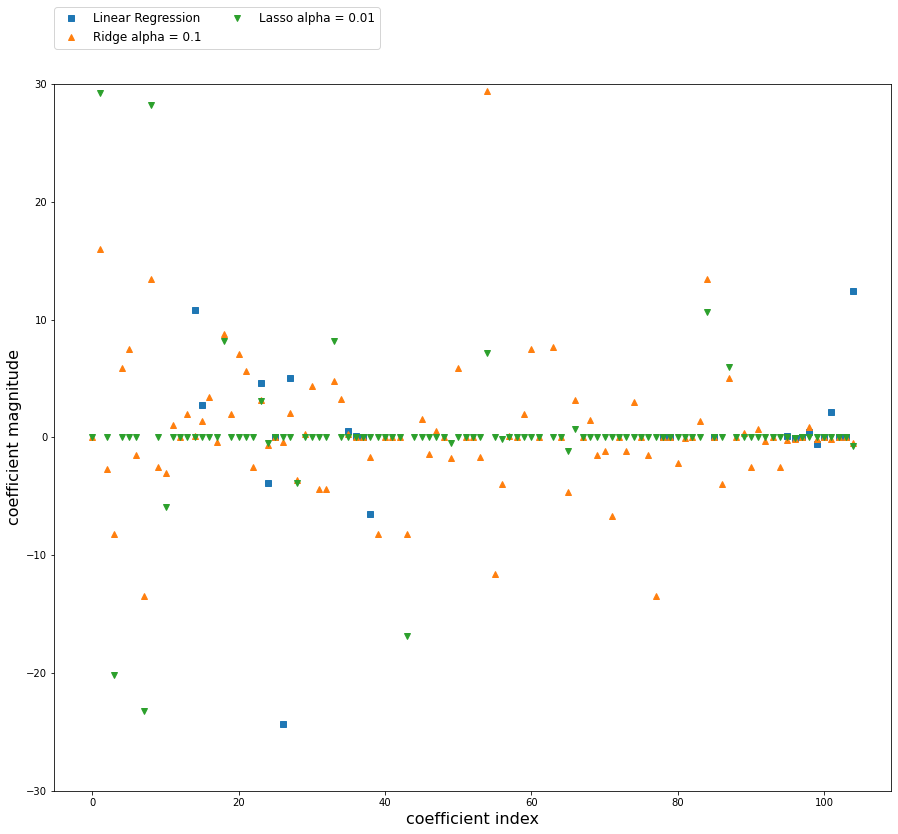

In [88]:
plt.plot(LR_model.coef_,'s',label = "Linear Regression")
plt.plot(Ridge_model.coef_,'^',label = "Ridge alpha = 0.1")
plt.plot(Lasso_model.coef_,'v',label = "Lasso alpha = 0.01")
#plt.plot(ElasticNet_model.coef_, label = "ElasticNet alpha=100")
plt.legend(ncol=2, loc=(0, 1.05), fontsize = 12)
plt.ylim(-30, 30)
plt.xlabel("coefficient index", fontsize = 16)
plt.ylabel("coefficient magnitude", fontsize = 16)

In [89]:
DecisionTreeRegressor_model = DecisionTreeRegressor(max_depth = 14, random_state=22)
run_model(DecisionTreeRegressor_model, train_X, train_y, test_X, sample, "HPB_results_DecisionTreeRegression.csv" )

Mean Absolute Error of train data =  17.1292933502998
RMSE of train data =  33.48464124777937
Cross validation Score  =  127.077200854272
Mean Absolute Percentage Error of train data =  18.769722947457286


In [90]:
print("Training set score DecisionTreeRegressor: {:.2f}".format(DecisionTreeRegressor_model.score(train_X, train_y)))
print("Number of features used DecisionTreeRegressor: {}".format(np.sum(DecisionTreeRegressor_model.feature_importances_ != 0)))

Training set score DecisionTreeRegressor: 0.95
Number of features used DecisionTreeRegressor: 75


In [91]:
GradientBoostingRegressor_model = GradientBoostingRegressor(max_depth = 12, random_state=42)
run_model(GradientBoostingRegressor_model,train_X, train_y, test_X, sample, "HPB_results_GradientBoostingRegression.csv" )

Mean Absolute Error of train data =  10.496989619488192
RMSE of train data =  19.495888654778767
Cross validation Score  =  111.3501200820554
Mean Absolute Percentage Error of train data =  13.281424935332033


In [92]:
print("Training set score GradientBoostingRegressor: {:.2f}".format(GradientBoostingRegressor_model.score(train_X, train_y)))
print("Number of features used GradientBoostingRegressor: {}".format(np.sum(GradientBoostingRegressor_model.feature_importances_ != 0)))

Training set score GradientBoostingRegressor: 0.98
Number of features used GradientBoostingRegressor: 87


In [93]:
XGBRegressor_model = XGBRegressor(max_depth = 8, random_state=42)
run_model(XGBRegressor_model, train_X, train_y, test_X, sample, "HPB_result_XGBRegression.csv" )

Mean Absolute Error of train data =  14.898908012438824
RMSE of train data =  25.013508995190488
Cross validation Score  =  105.48779227781363
Mean Absolute Percentage Error of train data =  17.883181185548654


In [94]:
print("Training set score XGBRegressor: {:.2f}".format(XGBRegressor_model.score(train_X, train_y)))
print("Number of features used XGBRegressor: {}".format(np.sum(XGBRegressor_model.feature_importances_ != 0)))

Training set score XGBRegressor: 0.97
Number of features used XGBRegressor: 66
